# Weather Dataset Analysis 

This notebook examines the weather datasets from Meteostat (retrieved from https://meteostat.net/de/ on 25th november 2022). The dataset is used as a vertical use case for cross-silo federated learning. The goal is to predict the air temperature for a single weather station, given a selection of attributes of the last *n* days from this station.

## Dataset Description

In [1]:
#import dependencies
import numpy as np
import pandas as pd
import seaborn as sns

from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../scripts')
import helper

2023-03-04 20:13:52.284162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 20:13:54.046916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-04 20:13:54.047041: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-04 20:13:54.047049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#load dataset
#the weather station Berlin Alexanderplatz is chosen as the examplary station
data = pd.read_csv("../datasets/horizontal/weather/berlin_alexanderplatz.csv", names=["date", "tavg", "tmin", "tmax", "prcp", "snow", "wdir", "wspd", "wpgt", "pres", "tsun"])
data.head()

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,1969-12-02,-1.3,-4.5,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1969-12-03,1.5,1.0,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1969-12-04,-0.5,-2.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1969-12-05,-3.2,-5.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1969-12-06,-2.1,-3.5,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tavg,16515.0,10.608653,7.861329,-17.6,4.6,10.6,16.8,31.1
tmin,16513.0,7.365076,6.997318,-18.7,2.2,7.4,13.0,24.7
tmax,16514.0,14.120358,8.975399,-14.9,7.1,14.1,21.1,38.0
prcp,11987.0,1.579361,3.642694,0.0,0.0,0.0,1.5,60.4
snow,4117.0,5.176099,23.663484,0.0,0.0,0.0,0.0,310.0
wdir,10598.0,208.351670,93.444179,0.0,131.0,235.0,280.0,360.0
wspd,11034.0,28.778204,15.034219,0.0,16.6,26.6,38.9,115.2
wpgt,8395.0,53.423204,21.768710,0.0,36.0,51.5,67.7,154.8
pres,11936.0,1010.997009,9.549732,961.3,1005.2,1011.3,1017.2,1044.8
tsun,31.0,15.483871,60.651942,0.0,0.0,0.0,0.0,276.0


[Text(0.5, 1.0, 'Measured temperature at Berlin Alexanderplatz')]

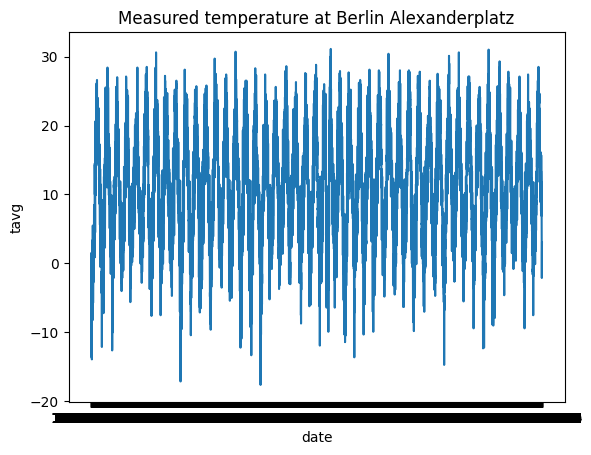

In [6]:
sns.lineplot(data, x="date", y="tavg").set(title="Measured temperature at Berlin Alexanderplatz")

[Text(0.5, 1.0, 'Measured temperature at Berlin Alexanderplatz within the last 365 days')]

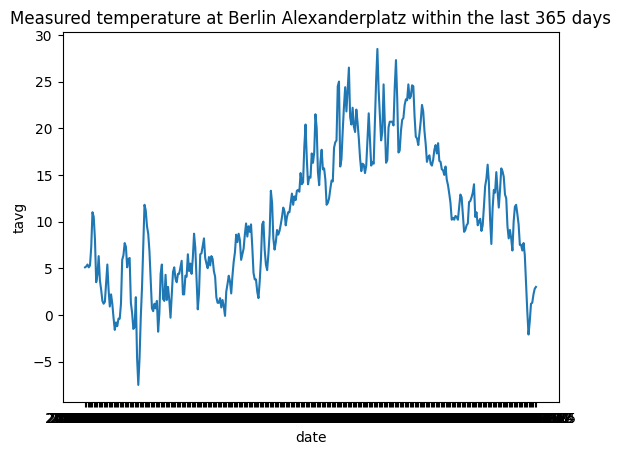

In [7]:
sns.lineplot(data.iloc[-365:], x="date", y="tavg").set(title="Measured temperature at Berlin Alexanderplatz within the last 365 days")

/tmp/ipykernel_279/2286279133.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


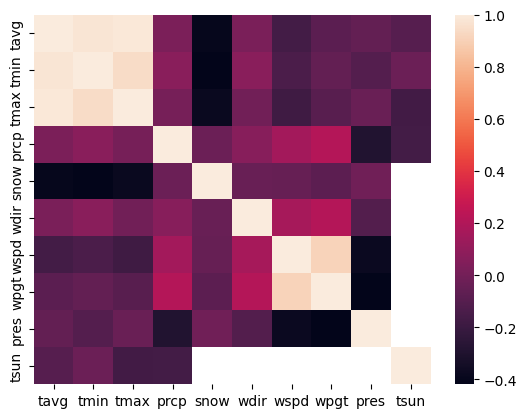

In [9]:
corr = data.corr()
sns.heatmap(corr, xticklabels=True, yticklabels=True)

plt.savefig("exports/weather/weather_correlation.svg")


In [7]:
corr.temp.describe()

count    10.000000
mean      0.220346
std       0.542975
min      -0.400857
25%      -0.096518
50%      -0.016535
75%       0.738686
max       1.000000
Name: temp, dtype: float64

In [8]:
corr.temp.sort_values(ascending=False).head(n=10)

temp    1.000000
rhum    0.987750
dwpt    0.976184
prcp    0.026191
wdir    0.023584
pres   -0.056654
wpgt   -0.086019
tsun   -0.100018
wspd   -0.166704
snow   -0.400857
Name: temp, dtype: float64

## Model Parameter Selection

This section finds the optimal parameters for models trained on the weather datasets. The selected attributes are *temp*, *rhum* and *dwpt*. Althought *snow* has a correlation of around -0.4 it is left out because only a fraction of records actually include this attribute. This is also the case for the other weather stations.

In [6]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


def _get_samples_from_weather_data(n: int, attributes: list[str], station: str, num_of_samples: int):
    """
    Generates samples from the covid dataset.
    Args:
        n (int): Numbers of records per sample.
        attributes (list[str]): List of attributes that will be used from the dataset. The fist element is the endogene variable.
        station (str): Name of the station.
        num_of_samples (int): Number of returned samples.
    """



    #load data
    path = f"/home/florian/bachelorarbeit/code/Cross-Silo-FL/datasets/horizontal/weather/{station}.csv"
    data = pd.read_csv(path, names=["time", "temp", "dwpt", "rhum", "prcp", "snow", "wdir", "wspd", "wpgt", "pres", "tsun", "coco"])
    data = data[attributes]
    data = data.dropna()
    #scale the data
    # data = data.drop("time", axis=1)
    # data_columns = data.columns
    # scaler = StandardScaler()
    # scaled_data = scaler.fit_transform(data)
    # data = pd.DataFrame(scaled_data, columns=data_columns)

    X = np.empty(shape=(num_of_samples, n*len(attributes)))
    y = np.empty(shape=(num_of_samples,))


    #split the data
    splitter = SlidingWindowSplitter(fh=1, window_length=n)
    samples = splitter.split_series(data[attributes].to_numpy())

    i = 0
    for features, label in samples:
        X[i] = features.flatten()
        y[i] = label[0][0]

        i += 1

        if i == num_of_samples:
            break

    return X, y


In [9]:
X, y  = _get_samples_from_weather_data(10, ["temp"], "berlin_alexanderplatz", 10000)

In [5]:
X.shape

(10000, 10)

In [6]:
y.shape

(10000,)

In [7]:
X[:2]

array([[-1.3,  1.5, -0.5, -3.2, -2.1, -2.4, -3.2, -3.8, -3.4,  0.4],
       [ 1.5, -0.5, -3.2, -2.1, -2.4, -3.2, -3.8, -3.4,  0.4,  0.5]])

In [8]:
y[:2]

array([ 0.5, -0.9])

In [2]:
X, y = helper.load_test_dataset("weather")

## Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [6]:
lm_params = {"fit_intercept": [True, False], "positive": [True, False]}
lm = LinearRegression()
lm_grid = GridSearchCV(lm, lm_params, scoring="neg_mean_absolute_error")

lm_grid.fit(X, y)
lm_grid.best_params_

{'fit_intercept': False, 'positive': True}

## Linear Support Vector Machine

In [7]:
from sklearn.svm import LinearSVR

In [8]:
svm_params = {"epsilon": [0,0.1,0.5,1,2,5,10], "tol": [0.0001, 0.001, 0.01, 0.1, 1, 0.00001], "C": [0.1,0.2,0.5,1,2,5,10]}
svm = LinearSVR()
svm_grid = GridSearchCV(svm, svm_params, scoring="neg_mean_absolute_error")

svm_grid.fit(X, y)
svm_grid.best_params_

/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

{'C': 0.2, 'epsilon': 0.1, 'tol': 0.0001}

In [35]:
svm = LinearSVR(C= 0.1, epsilon= 0, tol= 0.0001).fit(samples[0], samples[1])
svm.score(samples[0], samples[1])

/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9236075668638897

In [14]:
svm_grid.best_params_

{'C': 0.2, 'epsilon': 0.1, 'tol': 1e-05}

## Multi-Layer Perceptron

In [9]:
import keras_tuner as kt
import tensorflow as tf

In [12]:
#build a sequential model
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(30,)))

    #add dense layers to the model
    for i in range(hp.Int('number of layers', min_value=1, max_value=6)):
        neurons = hp.Int('layer_' + str(i), min_value=8, max_value=512, step=8)
        model.add(tf.keras.layers.Dense(neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    hp_learning_rate = hp.Choice("learning_rate", values=[0.1, 0.01, 0.001, 0.0001])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=["mean_absolute_error"])

    return model


tuner = kt.Hyperband(build_model,
                     objective="mean_absolute_error",
                     max_epochs=100,
                     factor=3,
                     directory= "./keras_tuner/weather/",
                     project_name= "weather_mlp_params")

stop_early = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", patience=5)

tuner.search(X, y, validation_split=0.2, epochs=50, callbacks=[stop_early, tf.keras.callbacks.TensorBoard("./keras_tuner/weather/mlp_tb_logs")])

tuner.results_summary()

Trial 254 Complete [00h 00m 10s]
mean_absolute_error: 0.4933391511440277

Best mean_absolute_error So Far: 0.4430927336215973
Total elapsed time: 00h 40m 54s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./keras_tuner/weather/weather_mlp_params
Showing 10 best trials
Trial summary
Hyperparameters:
number of layers: 5
layer_0: 248
learning_rate: 0.001
layer_1: 272
layer_2: 176
layer_3: 408
layer_4: 456
layer_5: 336
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0229
Score: 0.4430927336215973
Trial summary
Hyperparameters:
number of layers: 6
layer_0: 384
learning_rate: 0.0001
layer_1: 488
layer_2: 440
layer_3: 144
layer_4: 184
layer_5: 184
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0145
Score: 0.4522857069969177
Trial summary
Hyperparameters:
number of layers: 5
layer_0: 48
learning_rate: 0.001
layer_1: 184
layer_2: 64
layer_3: 96
layer_4: 240
layer_5: 344
tuner/epochs: 34
tuner/

In [13]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 248)               7688      
                                                                 
 dense_1 (Dense)             (None, 272)               67728     
                                                                 
 dense_2 (Dense)             (None, 176)               48048     
                                                                 
 dense_3 (Dense)             (None, 408)               72216     
                                                                 
 dense_4 (Dense)             (None, 456)               186504    
                                                                 
 dense_5 (Dense)             (None, 1)                 457       
                                                                 
Total params: 382,641
Trainable params: 382,641
Non-trai

## CNN

In [14]:
#build a sequential model
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((10, 3), input_shape=(30,)))
    #add Conv1D layers to the model
    for i in range(hp.Int('number of layers', min_value=1, max_value=4)):
        filters = hp.Int('filter_' + str(i), min_value=32, max_value=128, step=32)
        kernel_size = hp.Int('kernel_' + str(i), min_value=2, max_value=5, step=1)
        model.add(tf.keras.layers.Conv1D(filters, kernel_size, padding="same", activation="relu"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(hp.Int('dense_1', min_value=8, max_value=128, step=8), activation="relu"))
    model.add(tf.keras.layers.Dense(hp.Int('dense_2', min_value=8, max_value=128, step=8), activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    hp_learning_rate = hp.Choice("learning_rate", values=[0.1, 0.01, 0.001, 0.0001])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=["mean_absolute_error"])

    return model


cnn_tuner = kt.Hyperband(build_model,
                     objective="mean_absolute_error",
                     max_epochs=100,
                     factor=3,
                     directory= "./keras_tuner/weather/",
                     project_name= "weather_cnn_params")

stop_early = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", patience=5)

cnn_tuner.search(X, y, validation_split=0.2, epochs=50, callbacks=[stop_early, tf.keras.callbacks.TensorBoard("./keras_tuner/weather/cnn_tb_logs")])

cnn_tuner.results_summary()

Trial 254 Complete [00h 00m 21s]
mean_absolute_error: 0.36381852626800537

Best mean_absolute_error So Far: 0.3147168755531311
Total elapsed time: 00h 47m 18s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./keras_tuner/weather/weather_cnn_params
Showing 10 best trials
Trial summary
Hyperparameters:
number of layers: 2
filter_0: 128
kernel_0: 2
dense_1: 104
dense_2: 40
learning_rate: 0.001
filter_1: 96
kernel_1: 3
filter_2: 128
kernel_2: 4
filter_3: 96
kernel_3: 3
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0205
Score: 0.3147168755531311
Trial summary
Hyperparameters:
number of layers: 4
filter_0: 64
kernel_0: 3
dense_1: 80
dense_2: 96
learning_rate: 0.001
filter_1: 64
kernel_1: 5
filter_2: 96
kernel_2: 5
filter_3: 64
kernel_3: 3
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0243
Score: 0.31745046377182007
Trial summary
Hyperparameters:
number of layers: 2
filter_0: 128
kernel_0:

In [15]:
best_cnn_model = cnn_tuner.get_best_models()[0]
best_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 10, 3)             0         
                                                                 
 conv1d (Conv1D)             (None, 10, 128)           896       
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 96)            36960     
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 104)               99944     
                                                                 
 dense_1 (Dense)             (None, 40)                4200      
                                                                 
 dense_2 (Dense)             (None, 1)                 4

## LSTM

In [16]:
#build a sequential model
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((10, 3), input_shape=(30,)))
    #add Conv1D layers to the model
    for i in range(hp.Int('number of layers', min_value=1, max_value=4)):
        neurons = hp.Int('neurons_' + str(i), min_value=32, max_value=128, step=32)
        model.add(tf.keras.layers.LSTM(neurons, return_sequences=True))
    neurons_last_lstm = hp.Int('neurons_last_lstm', min_value=32, max_value=128, step=32)
    model.add(tf.keras.layers.LSTM(neurons_last_lstm))
    model.add(tf.keras.layers.Dense(hp.Int('dense_1', min_value=8, max_value=128, step=8), activation="relu"))
    model.add(tf.keras.layers.Dense(hp.Int('dense_2', min_value=8, max_value=128, step=8), activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    hp_learning_rate = hp.Choice("learning_rate", values=[0.1, 0.01, 0.001, 0.0001])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=["mean_absolute_error"])

    return model


lstm_tuner = kt.Hyperband(build_model,
                     objective="mean_absolute_error",
                     max_epochs=100,
                     factor=3,
                     directory= "./keras_tuner/weather/",
                     project_name= "weather_lstm_params")

stop_early = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", patience=5)

lstm_tuner.search(X, y, validation_split=0.2, epochs=50, callbacks=[stop_early, tf.keras.callbacks.TensorBoard("./keras_tuner/weather/lstm_tb_logs")])

lstm_tuner.results_summary()

Trial 149 Complete [00h 01m 45s]
mean_absolute_error: 0.5176928043365479

Best mean_absolute_error So Far: 0.37623104453086853
Total elapsed time: 01h 25m 38s

Search: Running Trial #150

Value             |Best Value So Far |Hyperparameter
4                 |1                 |number of layers
32                |128               |neurons_0
96                |64                |neurons_last_lstm
104               |24                |dense_1
24                |16                |dense_2
0.0001            |0.001             |learning_rate
64                |96                |neurons_1
128               |96                |neurons_2
64                |32                |neurons_3
4                 |100               |tuner/epochs
0                 |34                |tuner/initial_epoch
3                 |4                 |tuner/bracket
0                 |4                 |tuner/round

Epoch 1/4
500/500 [==============================] - 384s 747ms/step - loss: 0.7363 - mean_absolute_

: 

: 

In [ ]:
best_lstm_model = lstm_tuner.get_best_models()[0]
best_lstm_model.summary()

## Baseline Models

In [3]:
import time
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
#Samples are loaded and split into train test dataset; This is because the FL setting also splits datasets on the client

samples_berlin_alexanderplatz = helper.get_samples("weather", 10, ["temp", "rhum", "dwpt"], "berlin_alexanderplatz", False, max_samples=10000, standardize=True)


samples_frankfurt_am_main_westend = helper.get_samples("weather", 10, ["temp", "rhum", "dwpt"], "frankfurt_am_main_westend", False, max_samples=10000, standardize=True)
samples_hamburg_airport = helper.get_samples("weather", 10, ["temp", "rhum", "dwpt"], "hamburg_airport", False, max_samples=10000, standardize=True)
samples_leipzig = helper.get_samples("weather", 10, ["temp", "rhum", "dwpt"], "leipzig", False, max_samples=10000, standardize=True)
samples_muenchen = helper.get_samples("weather", 10, ["temp", "rhum", "dwpt"], "muenchen", False, max_samples=10000, standardize=True)
samples_potsdam = helper.get_samples("weather", 10, ["temp", "rhum", "dwpt"], "potsdam", False, max_samples=10000, standardize=True)
samples_hannover = helper.get_samples("weather", 10, ["temp", "rhum", "dwpt"], "hannover", False, max_samples=10000, standardize=True)
samples_koeln_bonn_airport = helper.get_samples("weather", 10, ["temp", "rhum", "dwpt"], "koeln_bonn_airport", False, max_samples=10000, standardize=True)
samples_stuttgart_schnarrenberg = helper.get_samples("weather", 10, ["temp", "rhum", "dwpt"], "stuttgart_schnarrenberg", False, max_samples=10000, standardize=True)
samples_weimar = helper.get_samples("weather", 10, ["temp", "rhum", "dwpt"], "weimar", False, max_samples=10000, standardize=True)

stations = [samples_berlin_alexanderplatz, samples_frankfurt_am_main_westend, samples_hamburg_airport, samples_leipzig, samples_muenchen, samples_potsdam, samples_hannover, samples_koeln_bonn_airport, samples_stuttgart_schnarrenberg, samples_weimar]

num_of_clients = [1,2,3,4,5,10]
all_splits = []

for i in num_of_clients:
    entries_per_station = math.floor(10000/i)

    X_samples = None
    y_samples = None

    for j in range(i):
        X_train, X_test, y_train, y_test = train_test_split(stations[j][0][:entries_per_station], stations[j][1][:entries_per_station], test_size=0.2, random_state=42)
        print(f'i: {i}, j: {j}, X_train: {np.isnan(np.sum(X_train))}, y_train: {np.isnan(np.sum(y_train))}')
        
        if type(X_samples) == type(None):
            X_samples = X_train
            y_samples = y_train

        else:
            X_samples = np.concatenate((X_samples, X_train), axis=0)
            y_samples = np.concatenate((y_samples, y_train), axis=0)

    all_splits.append((X_samples, y_samples))


# sample_one_client = samples_berlin_alexanderplatz
# sample_two_clients = (np.concatenate((samples_berlin_alexanderplatz[0][:5000], samples_frankfurt_am_main_westend[0][:5000]), axis=0), np.concatenate((samples_berlin_alexanderplatz[1][:5000], samples_frankfurt_am_main_westend[1][:5000]), axis=0))
# sample_three_clients =(np.concatenate((samples_berlin_alexanderplatz[0][:3334], samples_frankfurt_am_main_westend[0][:3333], samples_hamburg_airport[0][:3333]), axis=0), np.concatenate((samples_berlin_alexanderplatz[1][:3334], samples_frankfurt_am_main_westend[1][:3333], samples_hamburg_airport[1][:3333]), axis=0))
# sample_four_clients = ( np.concatenate((samples_berlin_alexanderplatz[0][:2500], samples_frankfurt_am_main_westend[0][:2500], samples_hamburg_airport[0][:2500], samples_leipzig[0][:2500]), axis=0), np.concatenate((samples_berlin_alexanderplatz[1][:2500], samples_frankfurt_am_main_westend[1][:2500], samples_hamburg_airport[1][:2500], samples_leipzig[1][:2500]), axis=0))
# sample_five_clients = ( np.concatenate((samples_berlin_alexanderplatz[0][:2000], samples_frankfurt_am_main_westend[0][:2000], samples_hamburg_airport[0][:2000], samples_leipzig[0][:2000], samples_muenchen[0][:2000]), axis=0), np.concatenate((samples_berlin_alexanderplatz[1][:2000], samples_frankfurt_am_main_westend[1][:2000], samples_hamburg_airport[1][:2000], samples_leipzig[1][:2000], samples_muenchen[1][:2000]), axis=0))

# sample_ten_clients = ( np.concatenate((samples_berlin_alexanderplatz[0][:1000], samples_frankfurt_am_main_westend[0][:1000], samples_hamburg_airport[0][:1000], samples_leipzig[0][:1000], samples_muenchen[0][:1000], samples_potsdam[0][:1000], samples_hannover[0][:1000], samples_koeln_bonn_airport[0][:1000], samples_stuttgart_schnarrenberg[0][:1000], samples_weimar[0][:1000]), axis=0), np.concatenate((samples_berlin_alexanderplatz[1][:1000], samples_frankfurt_am_main_westend[1][:1000], samples_hamburg_airport[1][:1000], samples_leipzig[1][:1000], samples_muenchen[1][:1000], samples_potsdam[1][:1000], samples_hannover[1][:1000], samples_koeln_bonn_airport[1][:1000], samples_stuttgart_schnarrenberg[1][:1000], samples_weimar[1][:1000]), axis=0))


i: 1, j: 0, X_train: False, y_train: False
i: 2, j: 0, X_train: False, y_train: False
i: 2, j: 1, X_train: False, y_train: False
i: 3, j: 0, X_train: False, y_train: False
i: 3, j: 1, X_train: False, y_train: False
i: 3, j: 2, X_train: False, y_train: False
i: 4, j: 0, X_train: False, y_train: False
i: 4, j: 1, X_train: False, y_train: False
i: 4, j: 2, X_train: False, y_train: False
i: 4, j: 3, X_train: False, y_train: False
i: 5, j: 0, X_train: False, y_train: False
i: 5, j: 1, X_train: False, y_train: False
i: 5, j: 2, X_train: False, y_train: False
i: 5, j: 3, X_train: False, y_train: False
i: 5, j: 4, X_train: False, y_train: False
i: 10, j: 0, X_train: False, y_train: False
i: 10, j: 1, X_train: False, y_train: False
i: 10, j: 2, X_train: False, y_train: False
i: 10, j: 3, X_train: False, y_train: False
i: 10, j: 4, X_train: False, y_train: False
i: 10, j: 5, X_train: False, y_train: False
i: 10, j: 6, X_train: False, y_train: False
i: 10, j: 7, X_train: False, y_train: False
i: 

In [59]:
# {
#     "model": {
#         "client_data1": [1,2,3],
#           ...
#          "client_time1": [4,5,6]
#     },
# }

baselines = {
    "linear_regression": {},
    "linearSVR": {},
    "MLP": {},
    "LSTM": {},
    "CNN": {}
}

In [6]:
#OLD METHOD; This method uses a different test dataset than the FL scenario
#X_train, X_test, y_train, y_test
one_client_splits = train_test_split(sample_one_client[0], sample_one_client[1], test_size=0.2)
two_clients_splits = train_test_split(sample_two_clients[0], sample_two_clients[1], test_size=0.2)
three_clients_splits = train_test_split(sample_three_clients[0], sample_three_clients[1], test_size=0.2)
four_clients_splits = train_test_split(sample_four_clients[0], sample_four_clients[1], test_size=0.2)
five_clients_splits = train_test_split(sample_five_clients[0], sample_five_clients[1], test_size=0.2)
ten_clients_splits = train_test_split(sample_ten_clients[0], sample_ten_clients[1], test_size=0.2)

OLD_all_splits = [one_client_splits, two_clients_splits, three_clients_splits, four_clients_splits, five_clients_splits, ten_clients_splits]

In [5]:
test_data = helper.load_test_dataset("weather")

### Linear Regression

In [60]:
from sklearn.linear_model import LinearRegression


for i, split in enumerate(all_splits):
    current_split_results = []
    current_split_time = []
    for _ in range(4):
        start = time.perf_counter()
        
        model = LinearRegression(fit_intercept= False, positive= True)
        model.fit(split[0], split[1])
        mae = mean_absolute_error(test_data[1], model.predict(test_data[0]))

        end = time.perf_counter()
        current_split_results.append(mae)
        current_split_time.append(end-start)
    
    if i == 5:
        baselines["linear_regression"].update({f"client_data{i+1}": current_split_results, f"client_time10": current_split_time})
    else:
        baselines["linear_regression"].update({f"client_data{i+1}": current_split_results, f"client_time{i+1}": current_split_time})



In [61]:
baselines["linear_regression"]

{'client_data1': [0.46848507480688484,
  0.46848507480688484,
  0.46848507480688484,
  0.46848507480688484],
 'client_time1': [0.01834340000004886,
  0.010407199999463046,
  0.018579399999907764,
  0.011517199999616423],
 'client_data2': [0.4725880315846257,
  0.4725880315846257,
  0.4725880315846257,
  0.4725880315846257],
 'client_time2': [0.01544819999980973,
  0.02181380000001809,
  0.01861780000035651,
  0.01580889999968349],
 'client_data3': [0.4706172106487164,
  0.4706172106487164,
  0.4706172106487164,
  0.4706172106487164],
 'client_time3': [0.01675950000026205,
  0.015130199999475735,
  0.014893100000335835,
  0.015005000000201107],
 'client_data4': [0.47468709933114706,
  0.47468709933114706,
  0.47468709933114706,
  0.47468709933114706],
 'client_time4': [0.01558619999923394,
  0.014738599999873259,
  0.014350899999953981,
  0.01621660000000702],
 'client_data5': [0.47807292340248186,
  0.47807292340248186,
  0.47807292340248186,
  0.47807292340248186],
 'client_time5': [0

### SVM

In [62]:
from sklearn.svm import LinearSVR

#baseline_svm = LinearSVR(**svm_grid.best_params_)

for i, split in enumerate(all_splits):
    current_split_results = []
    current_split_time = []
    for _ in range(4):
        start = time.perf_counter()

        model = LinearSVR(C= 0.2, epsilon= 0.1, tol= 0.0001)
        model.fit(split[0], split[1])
        mae = mean_absolute_error(test_data[1], model.predict(test_data[0]))

        end = time.perf_counter()
        current_split_results.append(mae)
        current_split_time.append(end-start)
    if i == 5:
        baselines["linearSVR"].update({f"client_data{i+1}": current_split_results, f"client_time10": current_split_time})
    else:
        baselines["linearSVR"].update({f"client_data{i+1}": current_split_results, f"client_time{i+1}": current_split_time})



/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

In [63]:
baselines["linearSVR"]

{'client_data1': [0.470837003669371,
  0.47083368406498355,
  0.47070790453931405,
  0.4708377620785725],
 'client_time1': [0.27223679999951855,
  0.39074799999980314,
  0.3017205999994985,
  0.3025834999998551],
 'client_data2': [0.4712015778318436,
  0.4710027243990028,
  0.4711305214931579,
  0.47112316889435163],
 'client_time2': [0.28960559999995894,
  0.2853192000002309,
  0.29896069999995234,
  0.2692735000000539],
 'client_data3': [0.46780603986281166,
  0.4677929822467748,
  0.46784699333312063,
  0.46789347559472716],
 'client_time3': [0.324248500000067,
  0.3174495000002935,
  0.3428100999999515,
  0.3106543000003512],
 'client_data4': [0.46891171312767066,
  0.46882087025008007,
  0.46878226730127026,
  0.46883460911947206],
 'client_time4': [0.3340010000001712,
  0.3143473999998605,
  0.36205729999983305,
  0.3222483999998076],
 'client_data5': [0.47140522935967255,
  0.4715322154346897,
  0.4715818260115044,
  0.4714620170405391],
 'client_time5': [0.30550289999973756,
  

### MLP

In [64]:
import tensorflow as tf

for i, split in enumerate(all_splits):
    current_split_results = []
    current_split_time = []
    for _ in range(4):
        start = time.perf_counter()
        #build model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(248, activation="relu"))
        model.add(tf.keras.layers.Dense(272, activation="relu"))
        model.add(tf.keras.layers.Dense(176, activation="relu"))
        model.add(tf.keras.layers.Dense(408, activation="relu"))
        model.add(tf.keras.layers.Dense(456, activation="relu"))
        model.add(tf.keras.layers.Dense(1, activation="linear"))
        model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanAbsoluteError())

        #train and evaluate
        model.fit(split[0], split[1], epochs=10, batch_size=32, verbose=0)
        mae = mean_absolute_error(test_data[1], model.predict(test_data[0]))

        end = time.perf_counter()
        current_split_results.append(mae)
        current_split_time.append(end-start)
    if i == 5:
        baselines["MLP"].update({f"client_data{i+1}": current_split_results, f"client_time10": current_split_time})
    else:
        baselines["MLP"].update({f"client_data{i+1}": current_split_results, f"client_time{i+1}": current_split_time})

625/625 [==============================] - 1s 2ms/step


In [65]:
baselines["MLP"]

{'client_data1': [0.4959135629479483,
  0.4902524268413104,
  0.5025666700320793,
  0.49542178028009193],
 'client_time1': [13.033838000000287,
  11.615313799999967,
  11.483624200000122,
  11.462418300000536],
 'client_data2': [0.4953703391077478,
  0.5005844001476375,
  0.5039296497623538,
  0.49083556029037234],
 'client_time2': [11.459044499999436,
  11.466643899999326,
  11.734163800000715,
  11.453220000000329],
 'client_data3': [0.4934492847857913,
  0.48684290433410427,
  0.5171799009375752,
  0.5014453453771728],
 'client_time3': [11.86792190000051,
  11.747859699999935,
  11.981810599999335,
  12.471474200000557],
 'client_data4': [0.4869782819927151,
  0.4971215148565539,
  0.49616836441591267,
  0.49658111981681957],
 'client_time4': [11.750915100000384,
  11.577144500000031,
  11.710846300000412,
  11.567903900000601],
 'client_data5': [0.5025336806697305,
  0.49900802940111133,
  0.49034474259618444,
  0.49451503162504507],
 'client_time5': [11.55894679999983,
  11.602261

### CNN

In [66]:
for i, split in enumerate(all_splits):
    current_split_results = []
    current_split_time = []
    for _ in range(4):
        start = time.perf_counter()
        #build model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Reshape((10,3), input_shape=(30,)))
        model.add(tf.keras.layers.Conv1D(128, 2, padding="same", activation="relu"))
        model.add(tf.keras.layers.Conv1D(96, 3, padding="same", activation="relu"))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(104, activation="relu"))
        model.add(tf.keras.layers.Dense(40, activation="relu"))
        model.add(tf.keras.layers.Dense(1, activation="linear"))

        model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=tf.keras.losses.MeanAbsoluteError())

        #train and evaluate
        model.fit(split[0], split[1], epochs=10, batch_size=32, verbose=0)
        mae = mean_absolute_error(test_data[1], model.predict(test_data[0]))

        end = time.perf_counter()
        current_split_results.append(mae)
        current_split_time.append(end-start)
    if i == 5:
        baselines["CNN"].update({f"client_data{i+1}": current_split_results, f"client_time10": current_split_time})
    else:
        baselines["CNN"].update({f"client_data{i+1}": current_split_results, f"client_time{i+1}": current_split_time})

625/625 [==============================] - 1s 1ms/step


In [67]:
baselines["CNN"]

{'client_data1': [0.47804905441849044,
  0.480067832768485,
  0.48172209277694183,
  0.48534764760630933],
 'client_time1': [10.048367800000051,
  9.27088189999995,
  9.341854800000874,
  9.147237099999984],
 'client_data2': [0.48495642400871486,
  0.4846082606854103,
  0.4792309682458152,
  0.4854327226140281],
 'client_time2': [9.365371799999593,
  9.119747200000347,
  9.144757600000048,
  9.888601999999992],
 'client_data3': [0.48262961868110077,
  0.4784943514917861,
  0.48090309855600183,
  0.4803466009767204],
 'client_time3': [9.481375299999854,
  8.893626399999448,
  9.18850409999959,
  9.018213499999547],
 'client_data4': [0.47990953376871004,
  0.47898189283423936,
  0.48461174722752604,
  0.479409211674803],
 'client_time4': [8.711532100000113,
  8.47026150000056,
  9.25864780000029,
  8.914585200000147],
 'client_data5': [0.48179952581631896,
  0.48668641531614487,
  0.4863717591762487,
  0.4860403308571014],
 'client_time5': [8.80972389999988,
  8.66485350000039,
  8.58891

### LSTM

In [68]:
for i, split in enumerate(all_splits):
    current_split_results = []
    current_split_time = []
    for _ in range(4):
        start = time.perf_counter()
        #build model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Reshape((10,3), input_shape=(30,)))
        model.add(tf.keras.layers.LSTM(128, return_sequences=True))
        model.add(tf.keras.layers.LSTM(64))
        model.add(tf.keras.layers.Dense(24, activation="relu"))
        model.add(tf.keras.layers.Dense(16, activation="relu"))
        model.add(tf.keras.layers.Dense(1, activation="linear"))

        model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.MeanAbsoluteError())

        #train and evaluate
        model.fit(split[0], split[1], epochs=10, batch_size=32, verbose=0)
        mae = mean_absolute_error(test_data[1], model.predict(test_data[0]))

        end = time.perf_counter()
        current_split_results.append(mae)
        current_split_time.append(end-start)
    if i == 5:
        baselines["LSTM"].update({f"client_data{i+1}": current_split_results, f"client_time10": current_split_time})
    else:
        baselines["LSTM"].update({f"client_data{i+1}": current_split_results, f"client_time{i+1}": current_split_time})

625/625 [==============================] - 4s 6ms/step


In [69]:
baselines["LSTM"]

{'client_data1': [0.47887943943215394,
  0.4763934198024816,
  0.47271987423483935,
  0.4742233769592396],
 'client_time1': [33.62904849999995,
  33.539985100000195,
  33.7529113999999,
  37.405102000000625],
 'client_data2': [0.47853053675343543,
  0.4756571769884956,
  0.48227237029519765,
  0.47785609634337334],
 'client_time2': [38.516369200000554,
  37.66933179999978,
  37.6004767000004,
  38.85023939999974],
 'client_data3': [0.4750162013801547,
  0.48248184501553304,
  0.47445969361363666,
  0.4771223131234],
 'client_time3': [42.96165440000004,
  42.07638330000009,
  43.795463700000255,
  42.57967210000061],
 'client_data4': [0.48098792471966945,
  0.4767085063357711,
  0.47551781041390295,
  0.4814131366673564],
 'client_time4': [38.78536919999988,
  39.703836200000296,
  39.3891107999998,
  39.8610520000002],
 'client_data5': [0.483762509103285,
  0.4850376715284997,
  0.47923462827776414,
  0.4770374205354331],
 'client_time5': [41.863341299999774,
  41.60511630000019,
  46.

In [70]:
import json
with open('exports/weather_baselines.json', 'w') as fp:
    json.dump(baselines, fp)

### Further analysis of linear regresssion and linear SVR

In [9]:
linear_baselines = {
    "linear regression": {},
    "linearSVR": {}
}

In [10]:
from sklearn.svm import LinearSVR

#baseline_svm = LinearSVR(**svm_grid.best_params_)

for i, split in enumerate(all_splits):
    current_split_results = []
    current_split_time = []
    for _ in range(20):
        start = time.perf_counter()

        model = LinearSVR(C= 0.2, epsilon= 0.1, tol= 0.0001)
        model.fit(split[0], split[1])
        mae = mean_absolute_error(test_data[1], model.predict(test_data[0]))

        end = time.perf_counter()
        current_split_results.append(mae)
        current_split_time.append(end-start)
    if i == 5:
        linear_baselines["linearSVR"].update({f"client_data{i+1}": current_split_results, f"client_time10": current_split_time})
    else:
        linear_baselines["linearSVR"].update({f"client_data{i+1}": current_split_results, f"client_time{i+1}": current_split_time})


/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

In [11]:
from sklearn.linear_model import LinearRegression


for i, split in enumerate(all_splits):
    current_split_results = []
    current_split_time = []
    for _ in range(20):
        start = time.perf_counter()
        
        model = LinearRegression(fit_intercept= False, positive= True)
        model.fit(split[0], split[1])
        mae = mean_absolute_error(test_data[1], model.predict(test_data[0]))

        end = time.perf_counter()
        current_split_results.append(mae)
        current_split_time.append(end-start)
    
    if i == 5:
        linear_baselines["linear regression"].update({f"client_data{i+1}": current_split_results, f"client_time10": current_split_time})
    else:
        linear_baselines["linear regression"].update({f"client_data{i+1}": current_split_results, f"client_time{i+1}": current_split_time})



In [15]:
import json
with open('exports/weather_linear_model_only_baselines.json', 'w') as fp:
    json.dump(linear_baselines, fp)